# Importing libraries and classes

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tabulate import tabulate

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import r2_score
from Utils import Utils

from sklearn.ensemble import RandomForestRegressor as SKLearnRandomForestRegressor
from sklearn.tree import DecisionTreeRegressor as SKLearnDecisionTreeRegressor
from sklearn.linear_model import LinearRegression as SKLearnLinearRegression

from DecisionTreeRegressor import DecisionTreeRegressor
from RandomForestRegressor import RandomForestRegressor
from LinearRegression import LinearRegression

# Reading and splitting the data

In [2]:
df = pd.read_csv('./NSO_Population_Sex_dataset/NSO_POPULATION_DATA_CLEANED.csv')

feature_cols = ['District', 'Sex', 'Year', 'Population_Growth_Rate','Average_Population']
X = pd.get_dummies(df[feature_cols], columns=['District', 'Sex'])
y = df["Population"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# SKLearn Decision Trees

In [3]:
SKLearn_Decision_Tree_Regressor = SKLearnDecisionTreeRegressor(max_depth=100, min_samples_split=2, min_samples_leaf=5)

SKLearn_Decision_Tree_Regressor.fit(X_train, y_train)

SKLearn_Decision_Tree_Regressor_Prediction = SKLearn_Decision_Tree_Regressor.predict(X_test)

SKLearn_Decision_Tree_Regressor_Prediction_MAE = mean_absolute_error(y_test, SKLearn_Decision_Tree_Regressor_Prediction)
SKLearn_Decision_Tree_Regressor_Prediction_MSE = mean_squared_error(y_test, SKLearn_Decision_Tree_Regressor_Prediction)
SKLearn_Decision_Tree_Regressor_Prediction_RMSE = Utils.root_mean_squared_error(y_test, SKLearn_Decision_Tree_Regressor_Prediction)
SKLearn_Decision_Tree_Regressor_Prediction_R2 = r2_score(y_test, SKLearn_Decision_Tree_Regressor_Prediction)

# Custom Decision Trees

In [4]:
Custom_Decision_Tree_Regressor = DecisionTreeRegressor(max_depth=100, min_samples_split=2)

Custom_Decision_Tree_Regressor.fit(X_train.values, y_train.values)

Custom_Decision_Tree_Regressor_Prediction = Custom_Decision_Tree_Regressor.predict(X_test.values)

Custom_Decision_Tree_Regressor_Prediction_MAE = mean_absolute_error(y_test, Custom_Decision_Tree_Regressor_Prediction)
Custom_Decision_Tree_Regressor_Prediction_MSE = mean_squared_error(y_test, Custom_Decision_Tree_Regressor_Prediction)
Custom_Decision_Tree_Regressor_Prediction_RMSE = Utils.root_mean_squared_error(y_test, Custom_Decision_Tree_Regressor_Prediction)
Custom_Decision_Tree_Regressor_Prediction_R2 = r2_score(y_test, Custom_Decision_Tree_Regressor_Prediction)

# Random Forest Regressor using SKLearn
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html

In [5]:
SKLearn_Random_Forest_Regressor = SKLearnRandomForestRegressor()
SKLearn_Random_Forest_Regressor.fit(X_train, y_train)

SKLearn_Random_Forest_Regressor_Prediction = SKLearn_Random_Forest_Regressor.predict(X_test)

SKLearn_Random_Forest_Regressor_Prediction_MAE = mean_absolute_error(y_test, SKLearn_Random_Forest_Regressor_Prediction)
SKLearn_Random_Forest_Regressor_Prediction_MSE = mean_squared_error(y_test, SKLearn_Random_Forest_Regressor_Prediction)
SKLearn_Random_Forest_Regressor_Prediction_RMSE = Utils.root_mean_squared_error(y_test, SKLearn_Random_Forest_Regressor_Prediction)
SKLearn_Random_Forest_Regressor_Prediction_R2 = r2_score(y_test, SKLearn_Random_Forest_Regressor_Prediction)


# Custom Random Forest Regressor using SKLearn Decision Trees

In [6]:
SKLearn_Decision_Trees_Random_Forest_Regressor = RandomForestRegressor(n_estimators=100, max_depth=None, custom=False)
SKLearn_Decision_Trees_Random_Forest_Regressor.fit(X_train, y_train)

SKLearn_Decision_Trees_Random_Forest_Regressor_Prediction = SKLearn_Decision_Trees_Random_Forest_Regressor.predict(X_test)

SKLearn_Decision_Trees_Random_Forest_Regressor_MAE = mean_absolute_error(y_test, SKLearn_Decision_Trees_Random_Forest_Regressor_Prediction)
SKLearn_Decision_Trees_Random_Forest_Regressor_MSE = mean_squared_error(y_test, SKLearn_Decision_Trees_Random_Forest_Regressor_Prediction)
SKLearn_Decision_Trees_Random_Forest_Regressor_RMSE = Utils.root_mean_squared_error(y_test, SKLearn_Decision_Trees_Random_Forest_Regressor_Prediction)
SKLearn_Decision_Trees_Random_Forest_Regressor_R2 = r2_score(y_test, SKLearn_Decision_Trees_Random_Forest_Regressor_Prediction)

# Custom Random Forest Regressor

In [7]:
Custom_Random_Forest_Regressor = RandomForestRegressor(n_estimators=100, max_depth=100)
Custom_Random_Forest_Regressor.fit(X_train, y_train)

Custom_Random_Forest_Regressor_Prediction = Custom_Random_Forest_Regressor.predict(X_test)

Custom_Random_Forest_Regressor_MAE = mean_absolute_error(y_test, Custom_Random_Forest_Regressor_Prediction)
Custom_Random_Forest_Regressor_MSE = mean_squared_error(y_test, Custom_Random_Forest_Regressor_Prediction)
Custom_Random_Forest_Regressor_RMSE = Utils.root_mean_squared_error(y_test, Custom_Random_Forest_Regressor_Prediction)
Custom_Random_Forest_Regressor_R2 = r2_score(y_test, Custom_Random_Forest_Regressor_Prediction)

# SKLearn Linear Regression

In [8]:
SKLearn_Linear_Regression = SKLearnLinearRegression()
SKLearn_Linear_Regression.fit(X_train, y_train)

SKLearn_Linear_Regression_Prediction = SKLearn_Linear_Regression.predict(X_test)

SKLearn_Linear_Regression_MAE = mean_absolute_error(y_test, SKLearn_Linear_Regression_Prediction)
SKLearn_Linear_Regression_MSE = mean_squared_error(y_test, SKLearn_Linear_Regression_Prediction)
SKLearn_Linear_Regression_RMSE = Utils.root_mean_squared_error(y_test, SKLearn_Linear_Regression_Prediction)
SKLearn_Linear_Regression_R2 = r2_score(y_test, SKLearn_Linear_Regression_Prediction)

# Custom Linear Regression

In [9]:
Custom_Linear_Regression = LinearRegression(learning_rate=0.01, num_iterations=1000)
Custom_Linear_Regression.fit(X_train, y_train)

Custom_Linear_Regression_Prediction = Custom_Linear_Regression.predict(X_test)

Custom_Linear_Regression_MAE = mean_absolute_error(y_test, Custom_Linear_Regression_Prediction)
Custom_Linear_Regression_MSE = mean_squared_error(y_test, Custom_Linear_Regression_Prediction)
Custom_Linear_Regression_RMSE = Utils.root_mean_squared_error(y_test, Custom_Linear_Regression_Prediction)
Custom_Linear_Regression_R2 = r2_score(y_test, Custom_Linear_Regression_Prediction)

# Scatter Plot

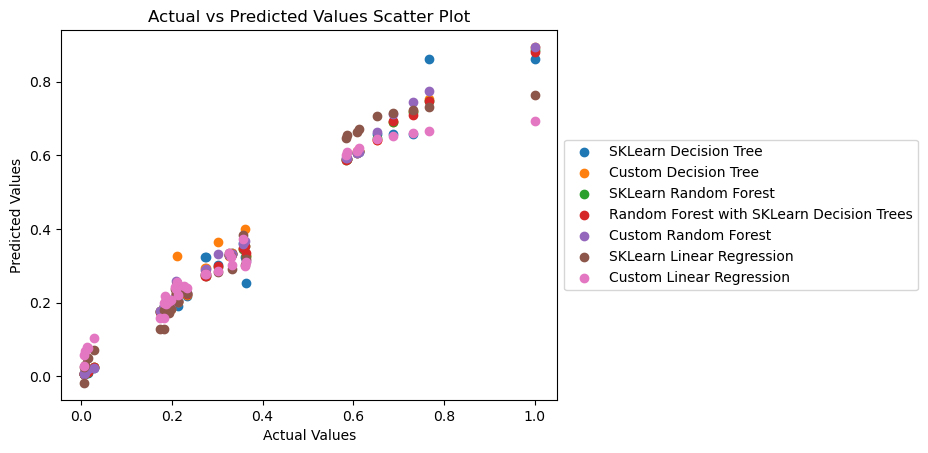

In [10]:
plt.scatter(y_test, SKLearn_Decision_Tree_Regressor_Prediction)
plt.scatter(y_test, Custom_Decision_Tree_Regressor_Prediction)
plt.scatter(y_test, SKLearn_Random_Forest_Regressor_Prediction)
plt.scatter(y_test, SKLearn_Decision_Trees_Random_Forest_Regressor_Prediction)
plt.scatter(y_test, Custom_Random_Forest_Regressor_Prediction)
plt.scatter(y_test, SKLearn_Linear_Regression_Prediction)
plt.scatter(y_test, Custom_Linear_Regression_Prediction)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values Scatter Plot')
plt.legend(['SKLearn Decision Tree', 'Custom Decision Tree', 'SKLearn Random Forest', 'Random Forest with SKLearn Decision Trees', 'Custom Random Forest', 'SKLearn Linear Regression', 'Custom Linear Regression'], loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

# Line Plot

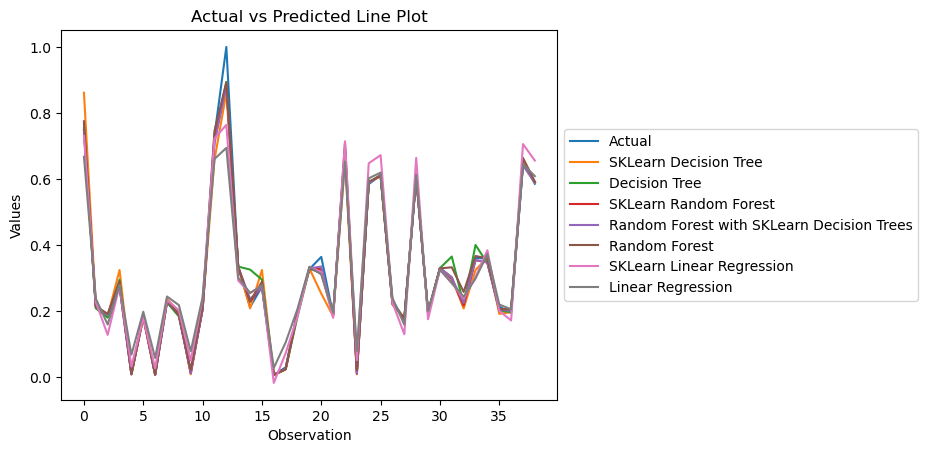

In [11]:
plt.plot(y_test.values, label='Actual')
plt.plot(SKLearn_Decision_Tree_Regressor_Prediction, label='SKLearn Decision Tree')
plt.plot(Custom_Decision_Tree_Regressor_Prediction, label='Decision Tree')
plt.plot(SKLearn_Random_Forest_Regressor_Prediction, label='SKLearn Random Forest')
plt.plot(SKLearn_Decision_Trees_Random_Forest_Regressor_Prediction, label='Random Forest with SKLearn Decision Trees')
plt.plot(Custom_Random_Forest_Regressor_Prediction, label='Random Forest')
plt.plot(SKLearn_Linear_Regression_Prediction, label='SKLearn Linear Regression')
plt.plot(Custom_Linear_Regression_Prediction, label='Linear Regression')
plt.xlabel('Observation')
plt.ylabel('Values')
plt.title('Actual vs Predicted Line Plot')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

# Residual Plot

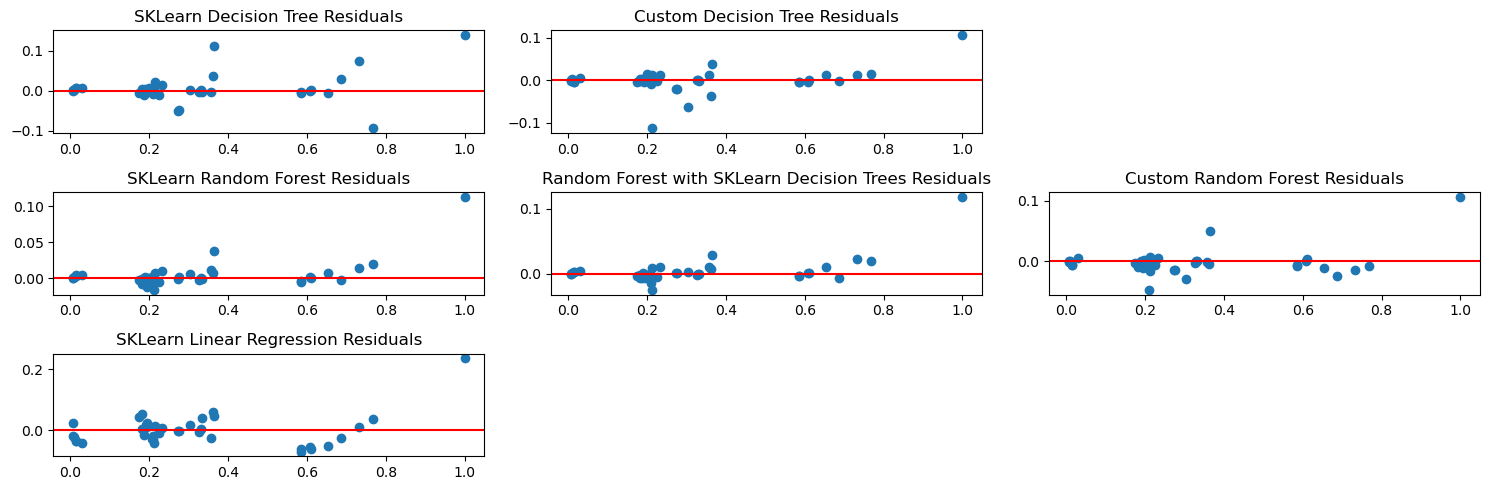

In [13]:
sklearn_decision_tree_regression_residulas = y_test - SKLearn_Decision_Tree_Regressor_Prediction
custom_decision_tree_residuals = y_test - Custom_Decision_Tree_Regressor_Prediction
sklearn_random_forest_residuals = y_test - SKLearn_Random_Forest_Regressor_Prediction
sklearn_decision_trees_random_forest_residuals = y_test - SKLearn_Decision_Trees_Random_Forest_Regressor_Prediction
custom_random_forest_residuals = y_test - Custom_Random_Forest_Regressor_Prediction
sklearn_Linear_regression_residuals = y_test - SKLearn_Linear_Regression_Prediction
custom_Linear_regression_residuals = y_test - Custom_Linear_Regression_Prediction

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 5))

axes[0,0].scatter(y_test, sklearn_decision_tree_regression_residulas)
axes[0,0].axhline(y=0, color='r', linestyle='-')
axes[0,0].set_title('SKLearn Decision Tree Residuals')

axes[0,1].scatter(y_test, custom_decision_tree_residuals)
axes[0,1].axhline(y=0, color='r', linestyle='-')
axes[0,1].set_title('Custom Decision Tree Residuals')

axes[1,0].scatter(y_test, sklearn_random_forest_residuals)
axes[1,0].axhline(y=0, color='r', linestyle='-')
axes[1,0].set_title('SKLearn Random Forest Residuals')

axes[1,1].scatter(y_test, sklearn_decision_trees_random_forest_residuals)
axes[1,1].axhline(y=0, color='r', linestyle='-')
axes[1,1].set_title('Random Forest with SKLearn Decision Trees Residuals')

axes[1,2].scatter(y_test, custom_random_forest_residuals)
axes[1,2].axhline(y=0, color='r', linestyle='-')
axes[1,2].set_title('Custom Random Forest Residuals')

axes[2,0].scatter(y_test, sklearn_Linear_regression_residuals)
axes[2,0].axhline(y=0, color='r', linestyle='-')
axes[2,0].set_title('SKLearn Linear Regression Residuals')

axes[2,1].scatter(y_test, custom_Linear_regression_residuals)
axes[2,1].axhline(y=0, color='r', linestyle='-')
axes[2,1].set_title('Custom Linear Regression Residuals')

axes[0,2].set_axis_off()
axes[2,1].set_axis_off()
axes[2,2].set_axis_off()

plt.tight_layout()
plt.show()

# Evaluations

In [32]:
table_data = {
    '': ['SKLearn Decision Tree Regressor', 'Custom Decision Tree Regressor', 'SKLearn Random Forest Regressor', 'Custom Random Forest Regressor using SKLearn Decision Trees', 'Custom Random Forest Regressor', 'SKLearn Linear Regression', 'Custom Linear Regression'],
    'Mean Absolute Error (MAE)': [SKLearn_Decision_Tree_Regressor_Prediction_MAE, Custom_Decision_Tree_Regressor_Prediction_MAE, SKLearn_Random_Forest_Regressor_Prediction_MAE, SKLearn_Decision_Trees_Random_Forest_Regressor_MAE, Custom_Random_Forest_Regressor_MAE, SKLearn_Linear_Regression_MAE, Custom_Linear_Regression_MAE],
    'Mean Squared Error (MSE)': [SKLearn_Decision_Tree_Regressor_Prediction_MSE, Custom_Decision_Tree_Regressor_Prediction_MSE, SKLearn_Random_Forest_Regressor_Prediction_MSE, SKLearn_Decision_Trees_Random_Forest_Regressor_MSE, Custom_Random_Forest_Regressor_MSE, SKLearn_Linear_Regression_MSE, Custom_Linear_Regression_MSE],
    'Root Mean Squared Error (RMSE)': [SKLearn_Decision_Tree_Regressor_Prediction_RMSE, Custom_Decision_Tree_Regressor_Prediction_RMSE, SKLearn_Random_Forest_Regressor_Prediction_RMSE, SKLearn_Decision_Trees_Random_Forest_Regressor_RMSE, Custom_Random_Forest_Regressor_RMSE, SKLearn_Linear_Regression_RMSE, Custom_Linear_Regression_RMSE],
    'R Squared (R\u00b2)': [SKLearn_Decision_Tree_Regressor_Prediction_R2, Custom_Decision_Tree_Regressor_Prediction_R2, SKLearn_Random_Forest_Regressor_Prediction_R2, SKLearn_Decision_Trees_Random_Forest_Regressor_R2, Custom_Random_Forest_Regressor_R2, SKLearn_Linear_Regression_R2, Custom_Linear_Regression_R2]
}

print(tabulate(table_data, headers='keys', tablefmt='fancy_grid'))

╒═════════════════════════════════════════════════════════════╤═════════════════════════════╤════════════════════════════╤══════════════════════════════════╤══════════════════╕
│                                                             │   Mean Absolute Error (MAE) │   Mean Squared Error (MSE) │   Root Mean Squared Error (RMSE) │   R Squared (R²) │
╞═════════════════════════════════════════════════════════════╪═════════════════════════════╪════════════════════════════╪══════════════════════════════════╪══════════════════╡
│ SKLearn Decision Tree Regressor                             │                  0.0147908  │                0.000784307 │                        0.0280055 │         0.982623 │
├─────────────────────────────────────────────────────────────┼─────────────────────────────┼────────────────────────────┼──────────────────────────────────┼──────────────────┤
│ Custom Decision Tree Regressor                              │                  0.00889056 │                0.0002

# Actual Results vs Predicted Values

In [33]:
results_table_data = {
    'Actual Results': y_test,
    'SKLearn Decision Tree Regressor Predictions': SKLearn_Decision_Tree_Regressor_Prediction,
    'Custom Decision Tree Regressor Predictions': Custom_Decision_Tree_Regressor_Prediction,
    'SKLearn Random Forest Regressor Predictions': SKLearn_Random_Forest_Regressor_Prediction,
    'Custom Random Forest Regressor using SKLearn Decision Trees Predictions': SKLearn_Decision_Trees_Random_Forest_Regressor_Prediction,
    'Custom Random Forest Regressor Predictions': Custom_Random_Forest_Regressor_Prediction,
    'SKLearn Linear Regressor Predictions': SKLearn_Linear_Regression_Prediction,
    'Custom Linear Regression Predictions': Custom_Linear_Regression_Prediction
}

print(tabulate(results_table_data, headers='keys', tablefmt='fancy_grid'))

╒══════════════════╤═══════════════════════════════════════════════╤══════════════════════════════════════════════╤═══════════════════════════════════════════════╤═══════════════════════════════════════════════════════════════════════════╤══════════════════════════════════════════════╤════════════════════════════════════════╤════════════════════════════════════════╕
│   Actual Results │   SKLearn Decision Tree Regressor Predictions │   Custom Decision Tree Regressor Predictions │   SKLearn Random Forest Regressor Predictions │   Custom Random Forest Regressor using SKLearn Decision Trees Predictions │   Custom Random Forest Regressor Predictions │   SKLearn Linear Regressor Predictions │   Custom Linear Regression Predictions │
╞══════════════════╪═══════════════════════════════════════════════╪══════════════════════════════════════════════╪═══════════════════════════════════════════════╪═══════════════════════════════════════════════════════════════════════════╪═══════════════════════